In [66]:
import matplotlib.pyplot as plt
from astropy.io import fits
import numpy as np

def open_fits_file(file_path):
    with fits.open(file_path, do_not_scale_image_data=True) as hdul:
        primary_hdu = hdul[0]
        image_data = primary_hdu.data

        bscale = primary_hdu.header.get('BSCALE', 1.0)
        bzero = primary_hdu.header.get('BZERO', 0.0)
        image_data = bscale * image_data + bzero
    return image_data

def scale_and_save(data, file_path):
    masked_image_data = np.ma.masked_invalid(data)
    mean_val = np.mean(masked_image_data)
    std_val = np.std(masked_image_data)
    vmin = mean_val - std_val
    vmax = mean_val + 2 * std_val

    scaled_data = np.clip(data, vmin, vmax)
    scaled_data = (scaled_data - vmin) / (vmax - vmin) 

    hdu = fits.PrimaryHDU(scaled_data)
    hdul = fits.HDUList([hdu])
    # hdul.writeto(f'{file_path[:-5]}_scaled.fits', overwrite=True)
    write_path = '../images/experiment 9/output/'+file_path[23:-5].replace('/', '_')+'_scaled.fits'
    hdul.writeto(write_path, overwrite=True)
    return scaled_data


def draw_circle(ax, x, y, radius, number, color='r'):
    circle = plt.Circle((x, y), radius, color=color, fill=False)
    ax.add_patch(circle)
    ax.text(x+25, y-25, str(number), color=color, fontsize=5, ha='center')

def calculate_flux(image, x, y, radius):
    y_grid, x_grid = np.ogrid[:image.shape[0], :image.shape[1]]
    mask = (x_grid - x)**2 + (y_grid - y)**2 <= radius**2
    flux = np.sum(image[mask])
    return flux, mask

def calculate_signal_to_noise_ratio(image_with_signal, file_path_signal, signal_coords, image_without_signal, file_path_nosignal, background_coords, radius=17, show=False):
    signal_scaled = scale_and_save(image_with_signal, file_path_signal)
    nosignal_scaled = scale_and_save(image_without_signal, file_path_nosignal)
    
    if show:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        ax1.imshow(signal_scaled, cmap='gray')
        for i, (signal_x, signal_y) in enumerate(signal_coords, 1):
            draw_circle(ax1, signal_x, signal_y, radius, i)
        ax2.imshow(nosignal_scaled, cmap='gray')
        for i, (background_x, background_y) in enumerate(background_coords, 1):
            draw_circle(ax2, background_x, background_y, radius, i)
        plt.show()

    snr_results = []
    for i, ((signal_x, signal_y), (background_x, background_y)) in enumerate(zip(signal_coords, background_coords), 1):
        flux_without_signal, mask_without_signal = calculate_flux(image_without_signal, background_x, background_y, radius)
        flux_with_signal, _ = calculate_flux(image_with_signal, signal_x, signal_y, radius)
        
        num_pixels_in_circle = np.sum(mask_without_signal)
        std_without_signal_circle = np.std(image_without_signal[mask_without_signal])

        snr = flux_with_signal / np.sqrt(flux_with_signal + num_pixels_in_circle * std_without_signal_circle)
        snr_results.append((signal_x, signal_y, snr))
        if show:
            print(f'Circle {i}:')
            print(f'  Flux with signal at ({signal_x}, {signal_y}): {flux_with_signal}')
            print(f'  Flux without signal at ({background_x}, {background_y}): {flux_without_signal}')
            print(f'  Signal-to-Noise Ratio (SNR) at ({signal_x}, {signal_y}): {snr}')

    return snr_results



### 515 LP filter LANO-FA1214M23-2M Lens

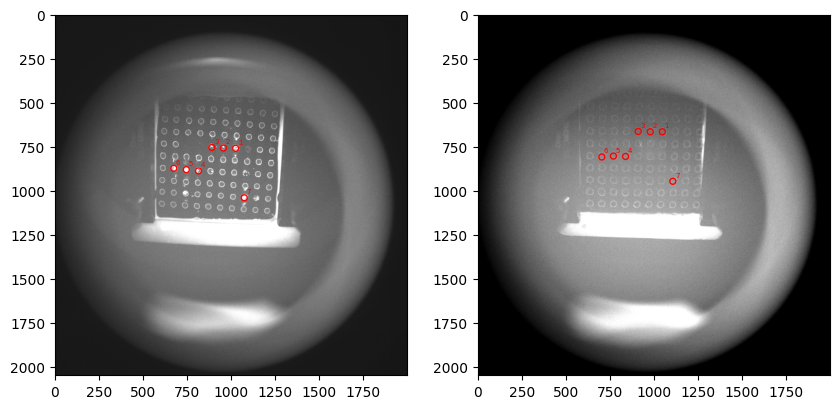

Circle 1:
  Flux with signal at (1026, 759): 2807900
  Flux without signal at (1049, 665): 323148
  Signal-to-Noise Ratio (SNR) at (1026, 759): 1665.6531027110443
Circle 2:
  Flux with signal at (957, 757): 790577
  Flux without signal at (980, 665): 332872
  Signal-to-Noise Ratio (SNR) at (957, 757): 871.3966931593035
Circle 3:
  Flux with signal at (891, 754): 665631
  Flux without signal at (912, 663): 325136
  Signal-to-Noise Ratio (SNR) at (891, 754): 795.2103083828695
Circle 4:
  Flux with signal at (815, 887): 1199320
  Flux without signal at (840, 805): 383322
  Signal-to-Noise Ratio (SNR) at (815, 887): 1078.6608861543052
Circle 5:
  Flux with signal at (746, 880): 2986426
  Flux without signal at (771, 803): 380616
  Signal-to-Noise Ratio (SNR) at (746, 880): 1718.0231040945982
Circle 6:
  Flux with signal at (675, 873): 3468893
  Flux without signal at (705, 808): 381767
  Signal-to-Noise Ratio (SNR) at (675, 873): 1852.723410745632
Circle 7:
  Flux with signal at (1075, 104

In [85]:
file_path_with_signal = '../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/with_signal_1.fits'
image_with_signal = open_fits_file(file_path_with_signal)

file_path_without_signal = '../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/without_signal_1.fits'
image_without_signal = open_fits_file(file_path_without_signal)

signal_coords = [(1026, 759), (957, 757), (891, 754), (815, 887), (746, 880), (675, 873), (1075, 1040)]  
background_coords = [(1049, 665), (980, 665), (912, 663), (840, 805), (771, 803), (705, 808), (1108, 946)]  

snr_results_1 = calculate_signal_to_noise_ratio(image_with_signal, file_path_with_signal, signal_coords, image_without_signal, file_path_without_signal, background_coords, radius=17, show=True)
print(f'SNR results: {snr_results_1}')


In [88]:
signal_coords = [(1026, 759), (957, 757), (891, 754), (815, 887), (746, 880), (675, 873), (1075, 1040)]  
background_coords = [(1049, 665), (980, 665), (912, 663), (840, 805), (771, 803), (705, 808), (1108, 946)]  
snr_accumulated = []

for i in range(1, 7):
    file_path_with_signal = f'../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/with_signal_{i}.fits'
    image_with_signal = open_fits_file(file_path_with_signal)

    file_path_without_signal = f'../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/without_signal_{i}.fits'
    image_without_signal = open_fits_file(file_path_without_signal)

    snr_results = calculate_signal_to_noise_ratio(image_with_signal, file_path_with_signal, signal_coords, image_without_signal, file_path_without_signal, background_coords, radius=17)
    snr_accumulated.append(snr_results)

snr_sums = [0] * len(signal_coords)

for snr_results in snr_accumulated:
    for j, (_, _, snr) in enumerate(snr_results):
        snr_sums[j] += snr

snr_averages = [snr_sum / len(snr_accumulated) for snr_sum in snr_sums]
for circle_number, average_snr in enumerate(snr_averages, 1):
    print(f'Average SNR for Circle {circle_number}: {average_snr}')

Average SNR for Circle 1: 1659.277997198971
Average SNR for Circle 2: 872.0990910178938
Average SNR for Circle 3: 795.5910985592227
Average SNR for Circle 4: 1078.923606102011
Average SNR for Circle 5: 1718.5844170987023
Average SNR for Circle 6: 1852.6089990695484
Average SNR for Circle 7: 2517.165033287925


### 515 LP filter 25mm 1:1:4 TV Lens

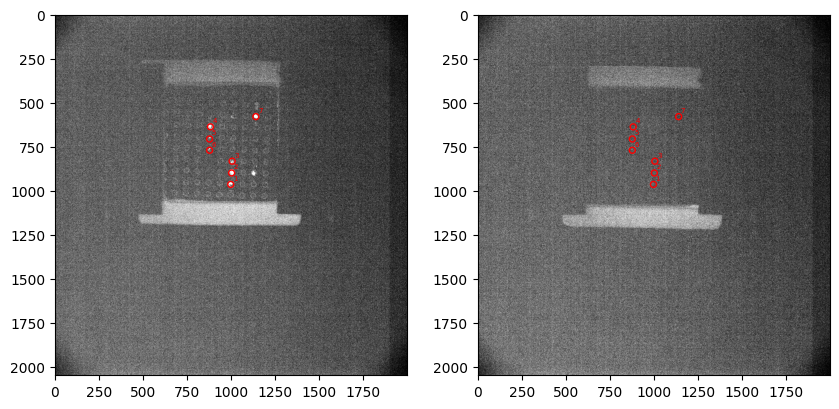

Circle 1:
  Flux with signal at (998, 964): 70404
  Flux without signal at (998, 964): 18067
  Signal-to-Noise Ratio (SNR) at (998, 964): 253.34502128445692
Circle 2:
  Flux with signal at (1003, 899): 48149
  Flux without signal at (1003, 899): 17999
  Signal-to-Noise Ratio (SNR) at (1003, 899): 205.87421430808524
Circle 3:
  Flux with signal at (1006, 832): 24526
  Flux without signal at (1006, 832): 17651
  Signal-to-Noise Ratio (SNR) at (1006, 832): 139.45610679561054
Circle 4:
  Flux with signal at (883, 637): 44012
  Flux without signal at (883, 637): 17551
  Signal-to-Noise Ratio (SNR) at (883, 637): 195.281999161684
Circle 5:
  Flux with signal at (878, 706): 20629
  Flux without signal at (878, 706): 17390
  Signal-to-Noise Ratio (SNR) at (878, 706): 125.09538675739692
Circle 6:
  Flux with signal at (878, 770): 20308
  Flux without signal at (878, 770): 17743
  Signal-to-Noise Ratio (SNR) at (878, 770): 124.04461543350018
Circle 7:
  Flux with signal at (1141, 579): 77535
  F

In [93]:
file_path_with_signal = '../images/experiment 9/100ms_515LPfilter_Emission/with_signal_1.fits'
image_with_signal = open_fits_file(file_path_with_signal)

file_path_without_signal = '../images/experiment 9/100ms_515LPfilter_Emission/without_signal_1.fits'
image_without_signal = open_fits_file(file_path_without_signal)

signal_coords = [(998, 964), (1003, 899), (1006, 832), (883, 637), (878, 706), (878, 770), (1141, 579)]  
background_coords = [(998, 964), (1003, 899), (1006, 832), (883, 637), (878, 706), (878, 770), (1141, 579)]   

snr_results_1 = calculate_signal_to_noise_ratio(image_with_signal, file_path_with_signal, signal_coords, image_without_signal, file_path_without_signal, background_coords, radius=17, show=True)
print(f'SNR results: {snr_results_1}')

In [94]:

snr_accumulated = []

for i in range(1, 7):
    file_path_with_signal = f'../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/with_signal_{i}.fits'
    image_with_signal = open_fits_file(file_path_with_signal)

    file_path_without_signal = f'../images/experiment 9/100ms_515LPfilter_Emission_LANO-FA1214M23-2M_Lens/without_signal_{i}.fits'
    image_without_signal = open_fits_file(file_path_without_signal)

    snr_results = calculate_signal_to_noise_ratio(image_with_signal, file_path_with_signal, signal_coords, image_without_signal, file_path_without_signal, background_coords, radius=17)
    snr_accumulated.append(snr_results)

snr_sums = [0] * len(signal_coords)

for snr_results in snr_accumulated:
    for j, (_, _, snr) in enumerate(snr_results):
        snr_sums[j] += snr

snr_averages = [snr_sum / len(snr_accumulated) for snr_sum in snr_sums]
for circle_number, average_snr in enumerate(snr_averages, 1):
    print(f'Average SNR for Circle {circle_number}: {average_snr}')

Average SNR for Circle 1: 644.1519310117961
Average SNR for Circle 2: 656.1663019651081
Average SNR for Circle 3: 659.474644336574
Average SNR for Circle 4: 504.96261078588276
Average SNR for Circle 5: 547.4308695746682
Average SNR for Circle 6: 559.787063796293
Average SNR for Circle 7: 457.64366616093895
